# EDA Introduction

In this notebook, we explore the main dataset of current applications.

Our goal are:
* Understand who are the clients / borrowers,
* Find useful statistics about the loans in our sample,
* Find relationships between the data that we have and our target variable (loan defaults).

Furthermore, we look into previous applications to see if additional files from the dataset can be of any help.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
dir_path = "/content/drive/MyDrive/Colab Notebooks/LoanDefaults/"
sys.path.append(dir_path + "utils/")

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plot_functions as my
import helper as hl

In [4]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 125)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
loans = pd.read_pickle(dir_path + "data/train.pkl")

In [6]:
muted = ["#ee854a", "#4878d0"]

style_params = {"hue_order": [True, False], "palette": muted}

# Main File

## Missing Values


In [7]:
nulls_info = hl.get_null_info(loans)
nulls_info.set_index("Column", inplace=True)
display(nulls_info)
most_nulls = nulls_info.T.sort_values(by="As Percentage", ascending=False)
print("In this dataset -",len(most_nulls[most_nulls["As Percentage"] >= 50]),
      "out of", loans.shape[1], "columns have at least half rows missing.")
display(most_nulls.head(10))

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EMERGENCYSTATE_MODE_MISSING,DAYS_EMPLOYED_ANOMALY
Column,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Null Counts,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,10.000,252.000,1152.000,0.000,0.000,0.000,0.000,0.000,0.000,49755.000,0.000,0.000,182691.000,0.000,0.000,0.000,0.000,0.000,0.000,86662.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,155955.000,599.000,54915.000,140425.000,161806.000,135017.000,184012.000,193324.000,147456.000,139331.000,137687.000,187768.000,164261.000,189143.000,138929.000,192099.000,152624.000,140425.000,161806.000,135017.000,184012.000,193324.000,147456.000,139331.000,137687.000,187768.000,164261.000,189143.000,138929.000,192099.000,152624.000,140425.000,161806.000,135017.000,184012.000,193324.000,147456.000,139331.000,137687.000,187768.000,164261.000,189143.000,138929.000,192099.000,152624.000,189237.000,138836.000,133600.000,140676.000,0.000,931.000,931.000,931.000,931.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,37380.000,37380.000,37380.000,37380.000,37380.000,37380.000,0.000,0.000
As Percentage,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.004,0.091,0.416,0.000,0.000,0.000,0.000,0.000,0.000,17.978,0.000,0.000,66.011,0.000,0.000,0.000,0.000,0.000,0.000,31.313,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,56.350,0.216,19.842,50.739,58.465,48.785,66.488,69.853,53.280,50.344,49.750,67.845,59.352,68.342,50.199,69.410,55.147,50.739,58.465,48.785,66.488,69.853,53.280,50.344,49.750,67.845,59.352,68.342,50.199,69.410,55.147,50.739,58.465,48.785,66.488,69.853,53.280,50.344,49.750,67.845,59.352,68.342,50.199,69.410

In this dataset - 41 out of 124 columns have at least half rows missing.


Column,Null Counts,As Percentage
COMMONAREA_MODE,193324.000,69.853
COMMONAREA_AVG,193324.000,69.853
COMMONAREA_MEDI,193324.000,69.853
NONLIVINGAPARTMENTS_MEDI,192099.000,69.410
NONLIVINGAPARTMENTS_AVG,192099.000,69.410
NONLIVINGAPARTMENTS_MODE,192099.000,69.410
FONDKAPREMONT_MODE,189237.000,68.376
LIVINGAPARTMENTS_MEDI,189143.000,68.342
LIVINGAPARTMENTS_AVG,189143.000,68.342
LIVINGAPARTMENTS_MODE,189143.000,68.342


We seem to have some columns that have systematically missing values, so we will have to be careful with how we deal with them.

### Data Dictionary


In [8]:
data_dict = pd.read_csv(
    dir_path + "original_data/HomeCredit_columns_description.csv",
    encoding="ISO-8859-1")

data_dict = data_dict[data_dict["Table"] == "application_{train|test}.csv"][
    ["Row", "Description", "Special"]]

print(data_dict.shape)
data_dict.head()

(122, 3)


,Row,Description,Special
0,SK_ID_CURR,ID of loan in our sample,NaN
1,TARGET,Target variable (1 - client with payment diffi...,NaN
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,CODE_GENDER,Gender of the client,NaN
4,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [9]:
def get_col_desc(col_name):
    return data_dict[data_dict["Row"] == col_name]["Description"].iloc[0]

assert get_col_desc("SK_ID_CURR") == "ID of loan in our sample"
get_col_desc("SK_ID_CURR")

'ID of loan in our sample'

# Exploratory Data Analysis


In [10]:
def remind_df():
    display(loans.describe())
    display(loans.head(3))

In [11]:
loans.drop(columns=["SK_ID_CURR"]).describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,276759.000,276759.000,276759.000,276749.000,276507.000,276759.000,276759.000,227004.000,276759.000,276759.000,94068.000,276757.000,276759.000,276759.000,276759.000,120804.000,276160.000,221844.000,136334.000,114953.000,141742.000,92747.000,83435.000,129303.000,137428.000,139072.000,88991.000,112498.000,87616.000,137830.000,84660.000,124135.000,136334.000,114953.000,141742.000,92747.000,83435.000,129303.000,137428.000,139072.000,88991.000,112498.000,87616.000,137830.000,84660.000,124135.000,136334.000,114953.000,141742.000,92747.000,83435.000,129303.000,137428.000,139072.000,88991.000,112498.000,87616.000,137830.000,84660.000,124135.000,143159.000,275828.000,275828.000,275828.000,275828.000,276758.000,239379.000,239379.000,239379.000,239379.000,239379.000,239379.000
mean,0.417,168853.241,599215.288,27109.410,538587.260,0.021,-16032.153,-2383.964,-4987.840,-2994.015,12.066,2.153,2.052,2.031,12.061,0.502,0.514,0.511,0.118,0.089,0.978,0.753,0.045,0.079,0.150,0.226,0.232,0.066,0.101,0.107,0.009,0.028,0.114,0.088,0.977,0.760,0.043,0.074,0.145,0.222,0.228,0.065,0.106,0.106,0.008,0.027,0.118,0.088,0.978,0.756,0.045,0.078,0.149,0.226,0.232,0.067,0.102,0.109,0.009,0.028,0.103,1.423,0.143,1.406,0.100,-962.988,0.006,0.007,0.034,0.267,0.265,1.899
std,0.720,247789.185,402518.161,14503.647,369452.720,0.014,4363.962,2340.121,3523.358,1509.159,11.936,0.909,0.509,0.503,3.262,0.211,0.191,0.195,0.108,0.083,0.059,0.113,0.076,0.135,0.100,0.145,0.161,0.081,0.093,0.111,0.048,0.070,0.108,0.084,0.065,0.110,0.074,0.132,0.101,0.144,0.161,0.082,0.098,0.112,0.046,0.070,0.109,0.082,0.060,0.112,0.076,0.135,0.101,0.145,0.162,0.082,0.094,0.112,0.047,0.070,0.107,2.411,0.447,2.390,0.361,827.238,0.084,0.110,0.204,0.915,0.613,1.869
min,0.000,25650.000,45000.000,1615.500,40500.000,0.000,-25229.000,-17912.000,-24672.000,-7197.000,0.000,1.000,1.000,1.000,0.000,0.015,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-4292.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,112500.000,270000.000,16537.500,238500.000,0.010,-19675.000,-3173.000,-7483.000,-4299.000,5.000,2.000,2.000,2.000,10.000,0.333,0.393,0.371,0.058,0.044,0.977,0.687,0.008,0.000,0.069,0.167,0.083,0.019,0.050,0.045,0.000,0.000,0.052,0.041,0.977,0.699,0.007,0.000,0.069,0.167,0.083,0.017,0.054,0.043,0.000,0.000,0.058,0.044,0.977,0.691,0.008,0.000,0.069,0.167,0.083,0.019,0.051,0.046,0.000,0.000,0.041,0.000,0.000,0.000,0.000,-1569.000,0.000,0.000,0.000,0.

First, let's take a look at the distribution of our target variable. Around 8% of Loans in our training set default with the majority being paid off.

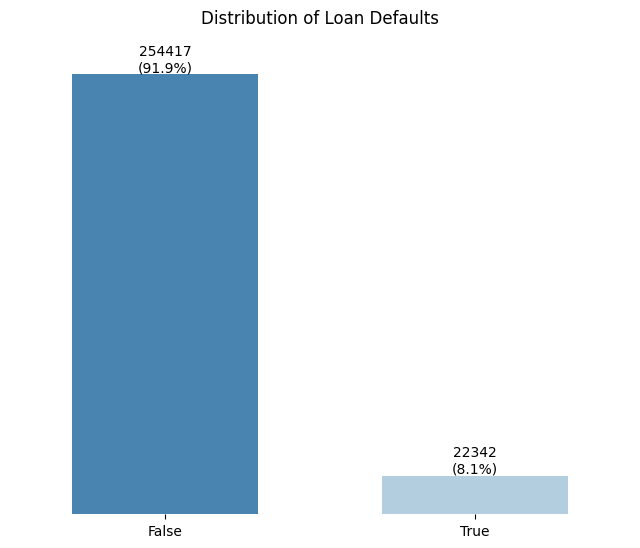

In [12]:
counts_df = loans.TARGET.value_counts().reset_index()
plt.figure(figsize=(8, 6))
my.plot_barchart(counts_df)

plt.title("Distribution of Loan Defaults\n")
plt.show()

## Who are the borrowers
In this section we are looking to explore who are the HomeCredit clients.


### Basic Information
Let's begin at looking at basic information: Gender, Age, Family status and Education.

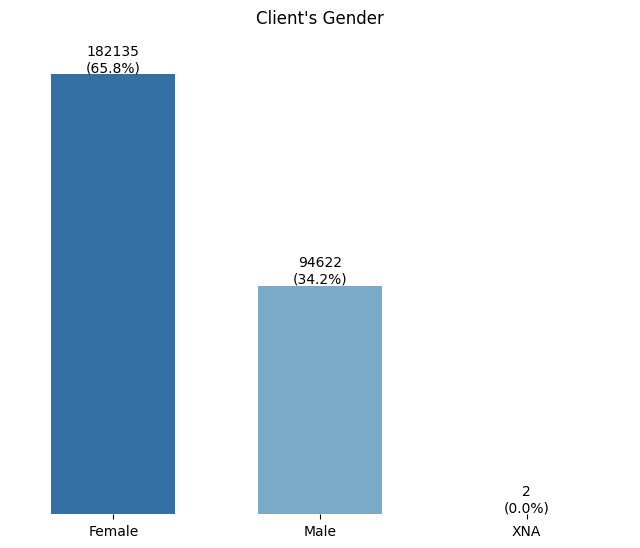

In [13]:
counts_df = loans.CODE_GENDER.value_counts().reset_index()
counts_df.columns = ["category", "count"]
counts_df["category"] = counts_df["category"].replace({"F": "Female", "M": "Male"})

plt.figure(figsize=(8, 6))
my.plot_barchart(counts_df)

plt.title("Client's Gender\n")
plt.show()

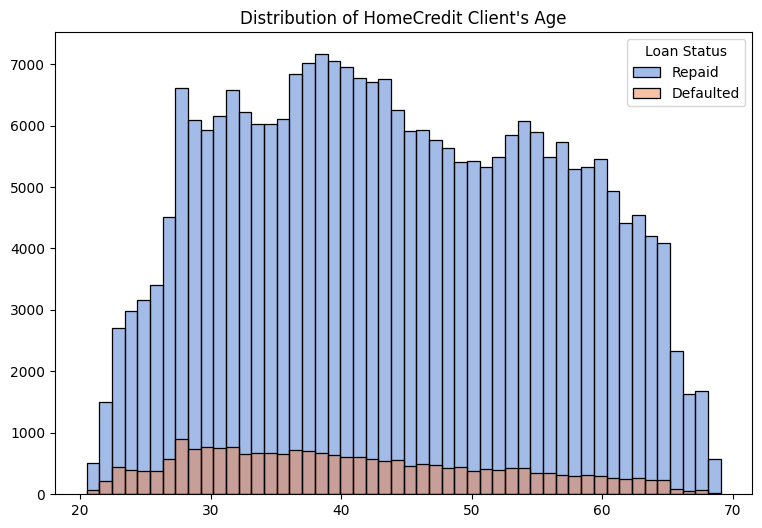

In [14]:
age = loans[["DAYS_BIRTH"]] / -365.25
age["Default"] = loans["TARGET"]

my.plot_hued_histogram(df=age, col_name="DAYS_BIRTH", hue_col="Default")
plt.title("Distribution of HomeCredit Client's Age")
plt.show()

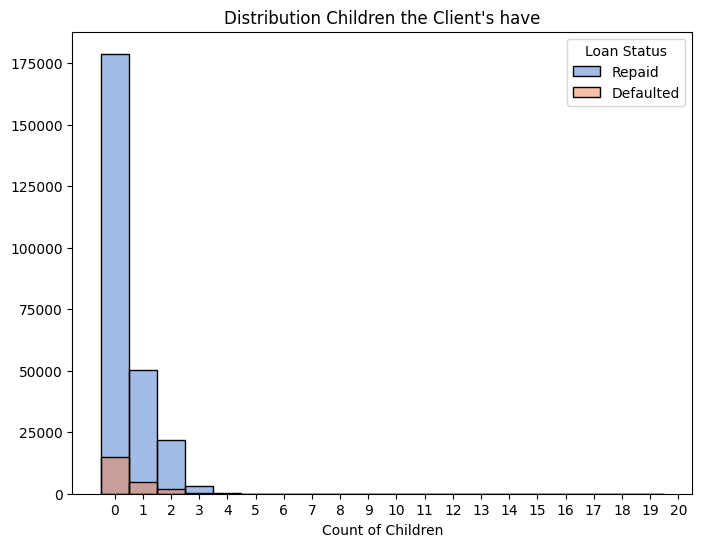

count   276759.000
mean         0.417
std          0.720
min          0.000
25%          0.000
50%          0.000
75%          1.000
max         19.000
Name: CNT_CHILDREN, dtype: float64


In [15]:
col_name = "CNT_CHILDREN"
bin_edges = np.arange(-0.5, loans[col_name].max() + 1.5)

plt.figure(figsize=(8,6))
sns.histplot(data=loans, x=col_name, bins=bin_edges, hue="TARGET", **style_params)

plt.title("Distribution Children the Client's have")

plt.xlabel("Count of Children")
plt.ylabel("")
plt.xticks(range(0, 21))

plt.legend(title="Loan Status", loc="upper right", labels=["Repaid", "Defaulted"])

plt.show();

print(loans[col_name].describe())

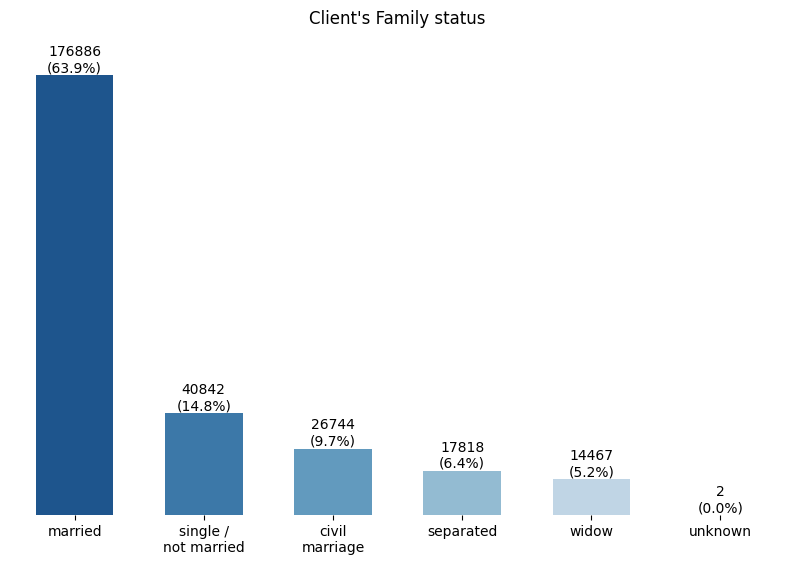

In [16]:
counts_df = loans.NAME_FAMILY_STATUS.value_counts().reset_index()

plt.figure(figsize=(10, 6))
my.plot_barchart(counts_df)

ax = plt.gca()
my.wrap_labels(ax=ax, width=11)

plt.title("Client's Family status\n")
plt.show()

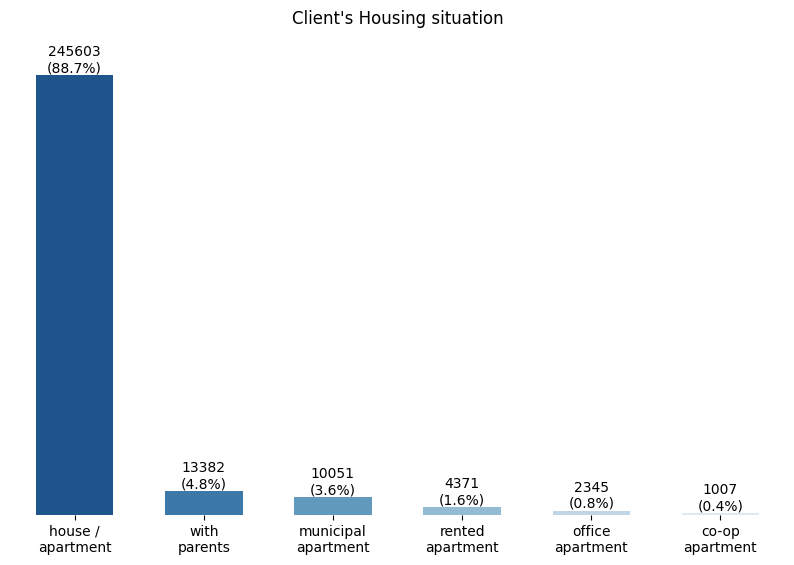

In [17]:
counts_df = loans.NAME_HOUSING_TYPE.value_counts().reset_index()

plt.figure(figsize=(10, 6))
my.plot_barchart(counts_df)

ax = plt.gca()
my.wrap_labels(ax=ax, width=11)

plt.title("Client's Housing situation\n")
plt.show()

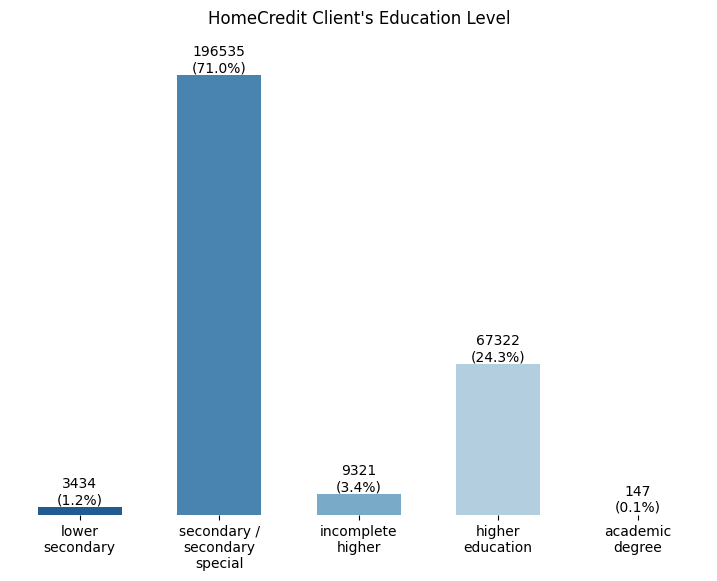

In [18]:
edu_order =  ["Lower secondary",  "Secondary / secondary special", "Incomplete higher", "Higher education", "Academic degree"]

edu_df = pd.DataFrame({"education": edu_order})

counts_df = loans.NAME_EDUCATION_TYPE.value_counts().reset_index()
counts_df.columns = ["education", "count"]

new_df = edu_df.merge(counts_df, on="education")
# Had to merge instead of sorting, due to a weird bug

fig = plt.figure(figsize=(9, 6))
my.plot_barchart(new_df, order=False)

ax = plt.gca()
my.wrap_labels(ax=ax, width=11)

plt.title("HomeCredit Client's Education Level\n")

plt.show()

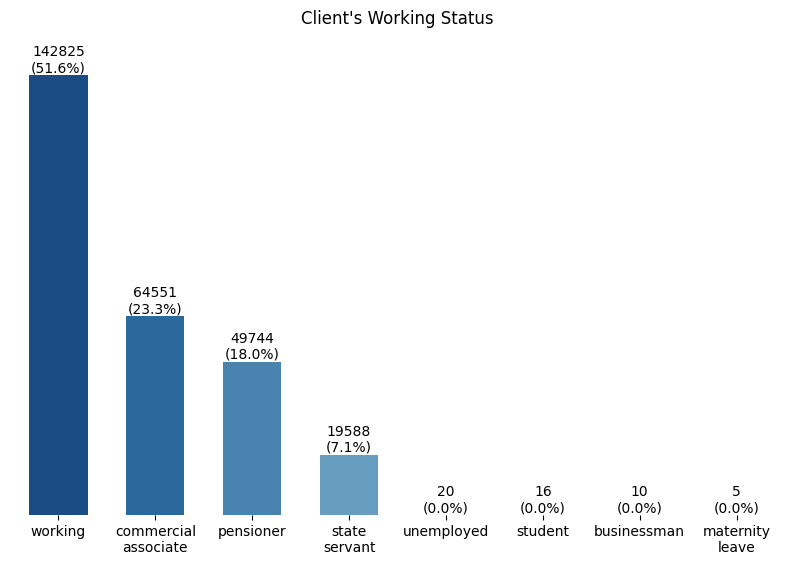

In [19]:
counts_df = loans.NAME_INCOME_TYPE.value_counts().reset_index()

plt.figure(figsize=(10, 6))
my.plot_barchart(counts_df)

ax = plt.gca()
my.wrap_labels(ax=ax, width=11)

plt.title("Client's Working Status\n")
plt.show()

* Majority of the clients (65%) are female.
* Age ranges from 20 to 70 years of age, with mean and median age's of ~43 years old.
* Majority of the client's are childless. Interestingly, there's one client with 19 children.
* Most borrowers (71%) have only secondary / secondary special education, with 24% having a higher education.
* 64% are married
* 89% are living in house / apartment.
* Most borrowers (71%) have only secondary / secondary special education, with 24% having a higher education.
* Over half are working, while additional 23% are "commercial associates", 7% are state servants, while the remaining 18% are pensioners.

### Income Information

Now that we have a broad understanding on our clients' basic information, let's look at data related to income, as it's highly important for them to be able to repay the loans.


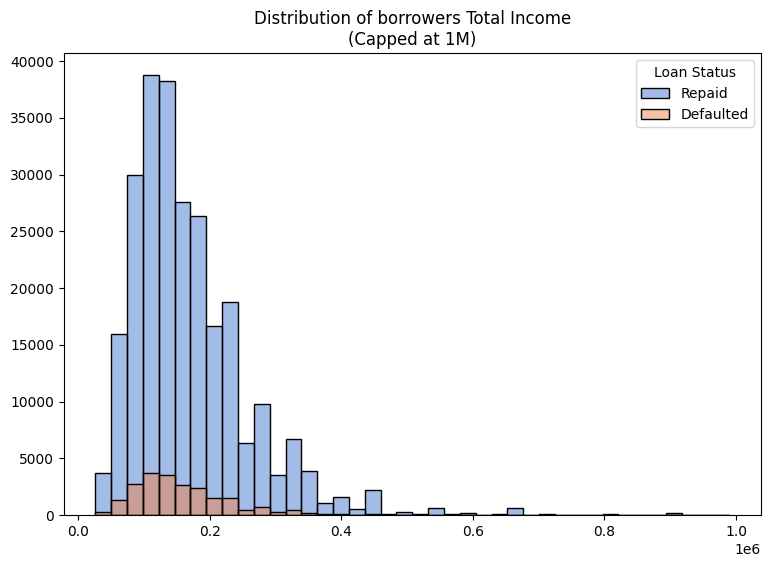

In [20]:
high_cap = 1000000
filtered_df = data=loans[loans["AMT_INCOME_TOTAL"]<=high_cap]

my.plot_hued_histogram(df=filtered_df, col_name="AMT_INCOME_TOTAL", bins=40)
plt.title("Distribution of borrowers Total Income\n(Capped at 1M)")
plt.show()

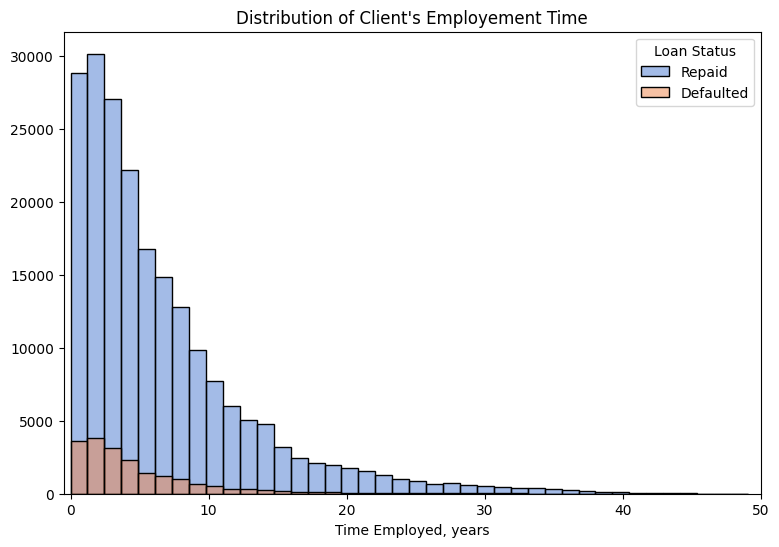

In [21]:
time_employed = loans[["DAYS_EMPLOYED"]] / -365.25
time_employed["TARGET"] = loans["TARGET"]

my.plot_hued_histogram(df=time_employed, col_name="DAYS_EMPLOYED", bins=40)
plt.title("Distribution of Client's Employement Time")
plt.xlim(-0.5, 50)
plt.xlabel("Time Employed, years")

plt.show()

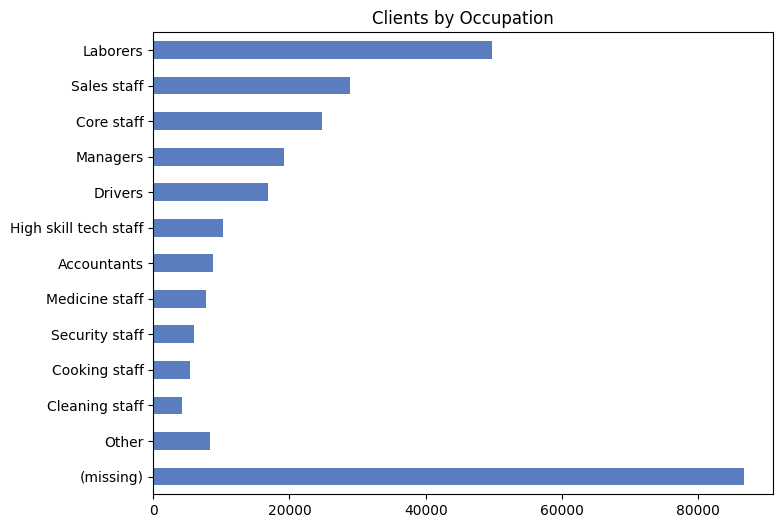

In [22]:
counts_df = loans.OCCUPATION_TYPE.value_counts().reset_index()
counts_df.columns = ["category", "count"]
n = 7

other = counts_df.tail(n)["count"].sum()
counts_df = counts_df.head(len(counts_df) - n)
other_row = pd.DataFrame({"category": ["Other"], "count": [other]})
counts_df = pd.concat([counts_df, other_row])

missing = len(loans) - counts_df["count"].sum()
missing_row = pd.DataFrame({"category": ["(missing)"], "count": [missing]})
counts_df = pd.concat([counts_df, missing_row])

plt.figure(figsize=(8, 6))

sns.barplot(data=counts_df, x="count", y="category", width=0.5, color=muted[1])
plt.title("Clients by Occupation")
plt.xlabel("")
plt.ylabel("")

plt.show()

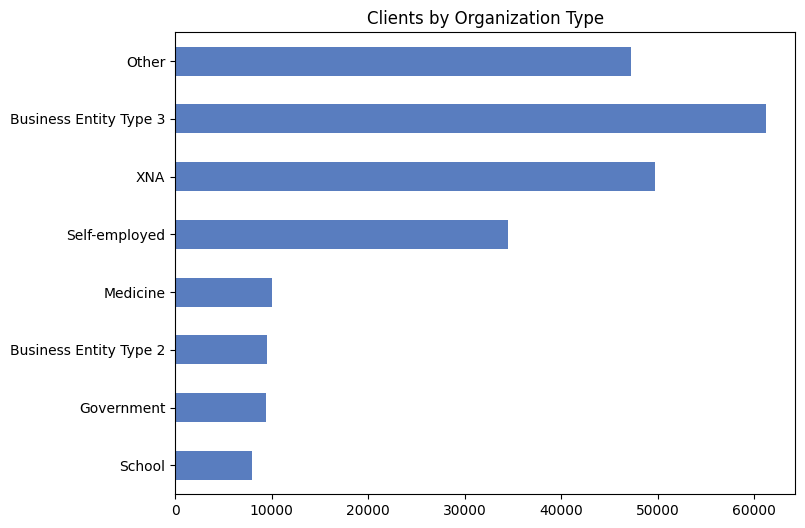

In [23]:
counts_df = loans.ORGANIZATION_TYPE.value_counts().reset_index()
counts_df.columns = ["category", "count"]

n = 8

other = counts_df.tail(len(counts_df) - n)["count"].sum()
counts_df = counts_df.head(n)
other_row = pd.DataFrame({"category": ["Other"], "count": [other]})
counts_df = pd.concat([counts_df, other_row])
counts_df = counts_df.sort_values(by="count", ascending=False)

plt.figure(figsize=(8, 6))

sns.barplot(data=counts_df, x="count", y="category", width=0.5, ci=None,
            color=muted[1])
plt.title("Clients by Organization Type")
plt.xlabel("")
plt.ylabel("")

plt.show()

## Loan Information

Now let's look at the financial data on loans themselves.

In [24]:
loans.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EMERGENCYSTATE_MODE_MISSING,DAYS_EMPLOYED_ANOMALY
234502,371646,False,Cash loans,F,False,True,0,180000.000,781920.000,28215.000,675000.000,Unaccompanied,Commercial associate,Higher education,Civil marriage,House / apartment,0.036,-13752,-4125.000,-638.000,-4548,NaN,True,True,False,True,True,False,Accountants,2.000,2,2,WEDNESDAY,11,False,True,True,False,True,True,Business Entity Type 3,NaN,0.504,0.356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.000,0.000,0.000,0.000,-105.000,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.000,0.000,0.000,0.000,0.000,1.000,True,False
34261,139700,False,Cash loans,F,True,True,1,202500.000,1006920.000,42790.500,900000.000,"Spouse, partner",Working,Higher education,Married,House / apartment,0.011,-10881,-3714.000,-142.000,-274,4.000,True,True,False,True,True,False,High skill tech staff,3.000,2,2,SATURDAY,10,False,False,False,True,False,True,Business Entity Type 3,NaN,0.324,NaN,0.088,0.048,0.982,0.755,0.031,0.080,0.035,0.458,0.042,0.046,0.071,0.076,0.000,0.000,0.089,0.050,0.982,0.765,0.032,0.081,0.035,0.458,0.042,0.048,0.078,0.080,0.000,0.000,0.088,0.048,0.982,0.758,0.031,0.080,0.035,0.458,0.042,0.047,0.073,0.078,0.000,0.000,org spec account,block of flats,0.077,"Stone, brick",False,0.000,0.000,0.000,0.000,-2257.000,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.000,0.000,0.000,0.000,0.000,0.000,False,False
265488,407492,False,Cash loans,F,False,False,0,36000.000,814041.000,23931.000,679500.000,Children,Pensioner,Secondary / secondary special,Single / 

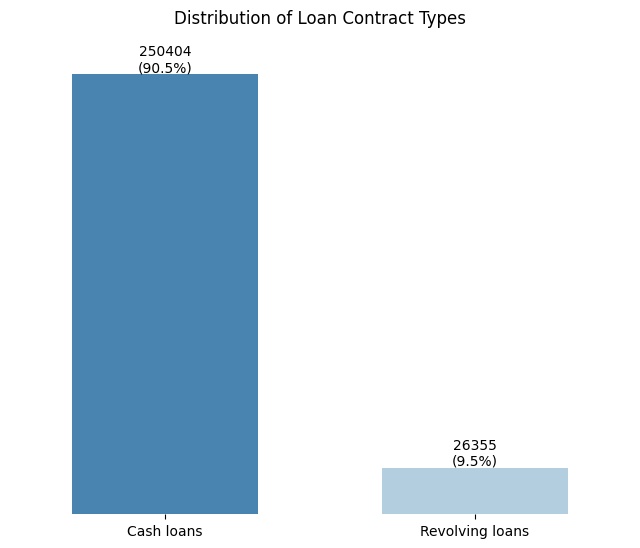

In [25]:
counts_df = loans.NAME_CONTRACT_TYPE.value_counts().reset_index()
plt.figure(figsize=(8, 6))
my.plot_barchart(counts_df)

plt.title("Distribution of Loan Contract Types\n")
plt.show()

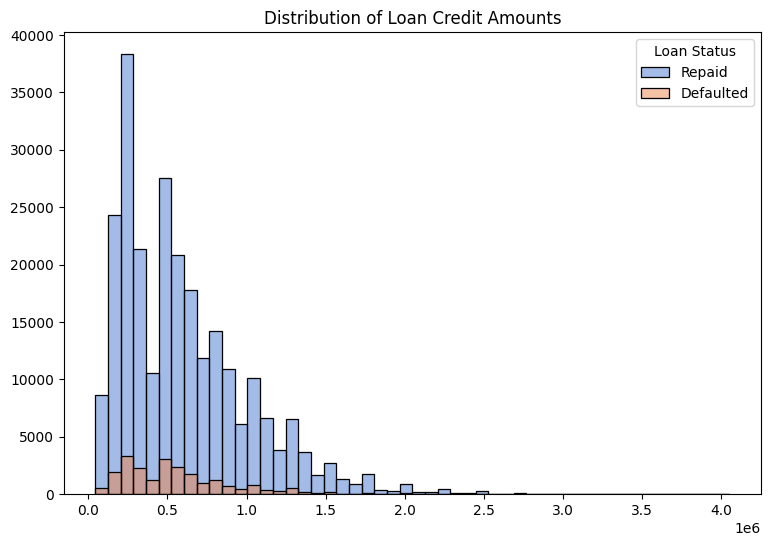

In [26]:
my.plot_hued_histogram(df=loans, col_name="AMT_CREDIT")
plt.title("Distribution of Loan Credit Amounts")

plt.show()

Looking at amount of credit, it seems to follow a somewhat normal distribution that is right-skewed. The average credit taken out was about 600k with the median value of 510k. The lowest credit taken out was ~45k while the extreme outlier on the high end was over 4M.


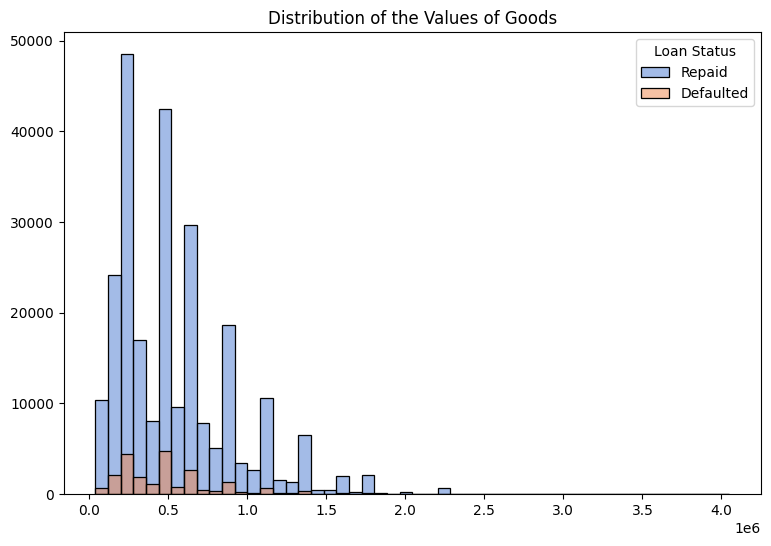

In [27]:
my.plot_hued_histogram(df=loans, col_name="AMT_GOODS_PRICE")
plt.title("Distribution of the Values of Goods")

plt.show()

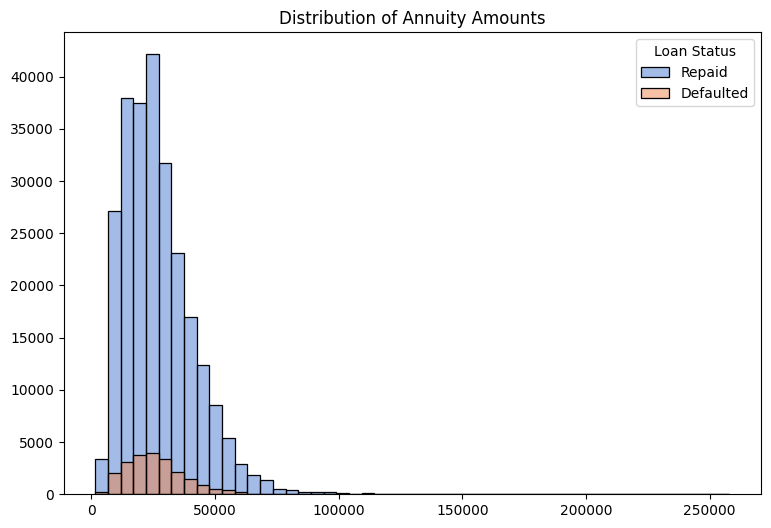

In [28]:
my.plot_hued_histogram(df=loans, col_name="AMT_ANNUITY")
plt.title("Distribution of Annuity Amounts")

plt.show()

## Flagged columns

In the dataframe, we have many boolean columns with "FLAG_" prefixes, indicating binary information.

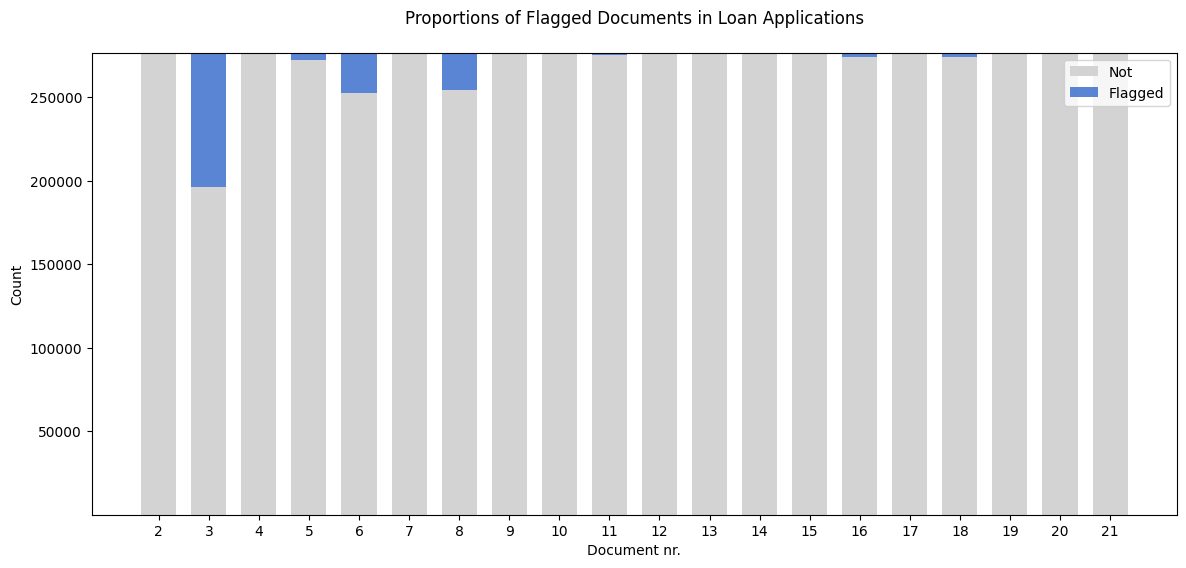

In [29]:
total_rows = len(loans)

flag_doc_cols = [f"FLAG_DOCUMENT_{n}" for n in range(2, 22)]
x_labels = range(2, 22)
zeros = np.array([loans[col].value_counts()[0] for col in flag_doc_cols])
ones = np.array([loans[col].value_counts()[1] for col in flag_doc_cols])

plt.figure(figsize=(14, 6))

plt.bar(x_labels, zeros, color="lightgrey", width=0.7)
plt.bar(x_labels, ones, color=muted[1], width=0.7, bottom=zeros, alpha=0.9)
plt.xticks(x_labels)

plt.xlabel("Document nr.")
plt.ylabel("Count")
plt.ylim(0.5, total_rows)

plt.legend(["Not", "Flagged"])
plt.title("Proportions of Flagged Documents in Loan Applications\n")

plt.show()

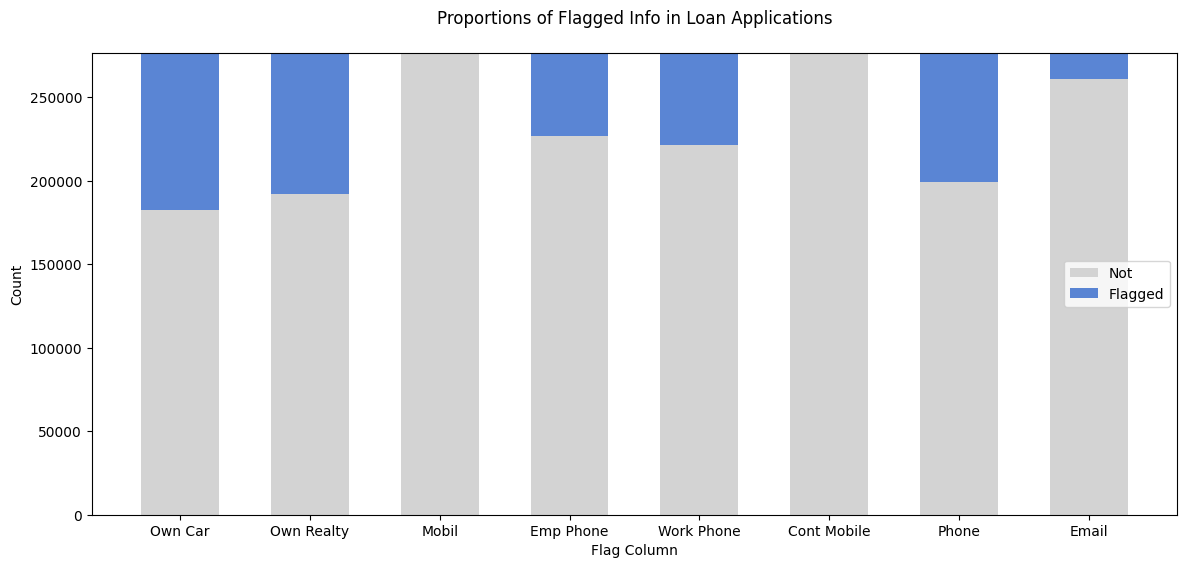

In [30]:
other_flag = []

for col in loans.columns:
    if "FLAG" in col and "DOCUMENT" not in col:
        other_flag.append(col)

zeros = np.array([loans[col].value_counts()[0] for col in other_flag])
ones = np.array([loans[col].value_counts()[1] for col in other_flag])
x_labels = [i.replace("FLAG_", "").replace("_", " ").title() for i in other_flag]

plt.figure(figsize=(14, 6))

plt.bar(x_labels, zeros, color="lightgrey", width=0.6)
plt.bar(x_labels, ones, color=muted[1], width=0.6, bottom=zeros, alpha=0.9)

plt.xlabel("Flag Column")
plt.ylabel("Count")
plt.ylim(0, total_rows)

plt.legend(["Not", "Flagged"], loc="center right")
plt.title("Proportions of Flagged Info in Loan Applications\n")

plt.show()

## EXT_SOURCE columns

In [31]:
print(get_col_desc("EXT_SOURCE_1"))

Normalized score from external data source


In the dataset, we have 3 columns that are only described as "external data source". These columns are normalized. They have a lot of predictive power in our prediction models, so it's unfortunate, that we don't have additional information about them. Nevertheless, let's take a look at their distributions.

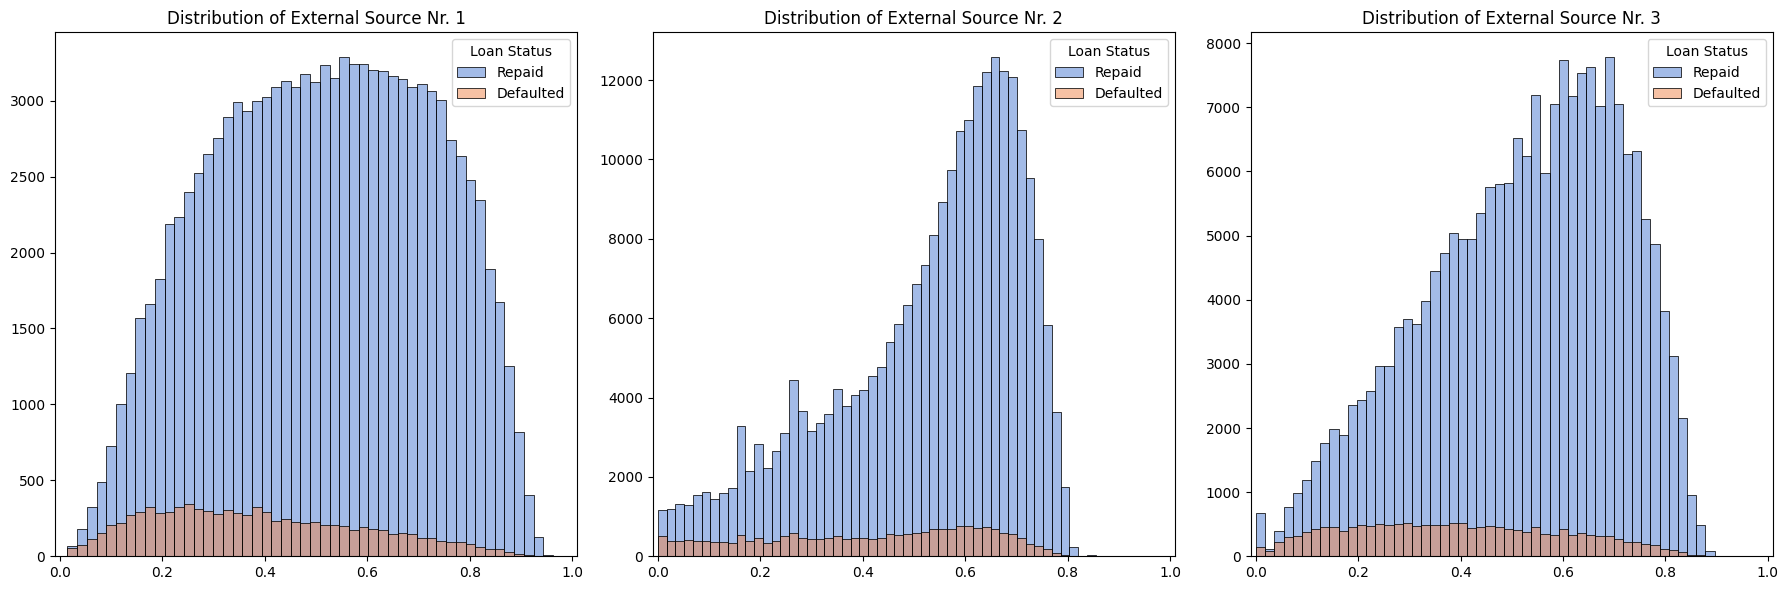

In [32]:
plt.figure(figsize=(18, 6))

for i in [1, 2, 3]:
    col_name = f"EXT_SOURCE_{i}"
    plt.subplot(1, 3, i)
    sns.histplot(data=loans, x=col_name, hue="TARGET", bins=50, alpha=0.5, **style_params)

    plt.title(f"Distribution of External Source Nr. {i}")
    plt.ylabel("")
    plt.xlabel("")
    plt.xlim(-0.01, 1.01)
    plt.legend(title="Loan Status", loc="upper right", labels=["Repaid", "Defaulted"])


plt.tight_layout()
plt.show()

* For External Source 1: there's definitely a trend here. Non defaulted loans seem to have a normal distribution, while defaulted loans distribution looks much more right-skewed.
* For External Source 2: Majority of the paid off loans have higher values then defaulted loans. There doesn't seem to be any values higher then 0.85.
* For External Source 2: Again, the distribution of paid of loans is shifted towards the right (left-skewed), while the defaulted loans are more uniform / shift towards left (right-skewed). There doesn't seem to be any values higher then 0.90.


In [33]:
loans[loans["TARGET"]==1].describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,22342.000,22342.000,22342.000,22342.000,22342.000,22322.000,22342.000,22342.000,19654.000,22342.000,22342.000,6796.000,22342.000,22342.000,22342.000,22342.000,9067.000,22296.000,17251.000,9500.000,7939.000,9923.000,6383.000,5779.000,8946.000,9560.000,9694.000,6154.000,7875.000,6050.000,9647.000,5857.000,8569.000,9500.000,7939.000,9923.000,6383.000,5779.000,8946.000,9560.000,9694.000,6154.000,7875.000,6050.000,9647.000,5857.000,8569.000,9500.000,7939.000,9923.000,6383.000,5779.000,8946.000,9560.000,9694.000,6154.000,7875.000,6050.000,9647.000,5857.000,8569.000,10016.000,22308.000,22308.000,22308.000,22308.000,22342.000,18492.000,18492.000,18492.000,18492.000,18492.000,18492.000
mean,277567.920,0.465,166104.654,557417.271,26484.979,488733.766,0.019,-14864.077,-1810.084,-4485.431,-2738.729,13.655,2.182,2.153,2.135,11.796,0.387,0.411,0.390,0.106,0.082,0.976,0.744,0.040,0.062,0.143,0.203,0.213,0.063,0.093,0.094,0.008,0.025,0.104,0.082,0.975,0.751,0.039,0.059,0.139,0.200,0.209,0.062,0.098,0.094,0.008,0.024,0.107,0.082,0.975,0.747,0.040,0.061,0.142,0.203,0.212,0.064,0.094,0.095,0.008,0.025,0.090,1.499,0.191,1.480,0.137,-810.752,0.007,0.008,0.035,0.229,0.258,2.027
std,102320.630,0.758,786613.788,346926.799,12485.911,312013.272,0.012,4188.735,1840.465,3299.402,1516.217,12.499,0.953,0.506,0.501,3.283,0.205,0.213,0.205,0.102,0.075,0.070,0.112,0.069,0.119,0.098,0.135,0.149,0.081,0.089,0.101,0.048,0.063,0.102,0.076,0.075,0.109,0.068,0.117,0.099,0.134,0.149,0.081,0.095,0.102,0.048,0.064,0.102,0.075,0.071,0.111,0.069,0.119,0.098,0.135,0.149,0.081,0.090,0.102,0.048,0.064,0.099,2.391,0.516,2.369,0.427,757.456,0.085,0.107,0.206,0.749,0.642,1.936
min,100002.000,0.000,27000.000,45000.000,2722.500,45000.000,0.001,-25168.000,-14540.000,-19706.000,-6203.000,0.000,1.000,1.000,1.000,0.000,0.015,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-4054.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,189685.250,0.000,112500.000,284400.000,17348.625,238500.000,0.010,-18010.500,-2380.750,-6646.000,-4122.000,6.000,2.000,2.000,2.000,10.000,0.222,0.239,0.224,0.041,0.040,0.976,0.680,0.007,0.000,0.069,0.125,0.083,0.018,0.045,0.035,0.000,0.000,0.038,0.036,0.976,0.686,0.007,0.000,0.069,0.125,0.083,0.016,0.044,0.033,0.000,0.000,0.042,0.039,0.976,0.685,0.007,0.000,0.069,0.125,0.083,0.018,0.046,0.035,0.000,0.000,0.032,0.000,0.000,0.000,0.000,-1302.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,276573.000,0.00

## Multivariate Analysis

AMT_INCOME_TOTAL :
Bounds: -22500.0 - 337500.0
12678 rows removed.

AMT_CREDIT :
Bounds: -511245.0 - 1572075.0
5148 rows removed.

AMT_ANNUITY :
Bounds: -8597.25 - 57336.75
4462 rows removed.

AMT_GOODS_PRICE :
Bounds: -450000.0 - 1350000.0
1679 rows removed.



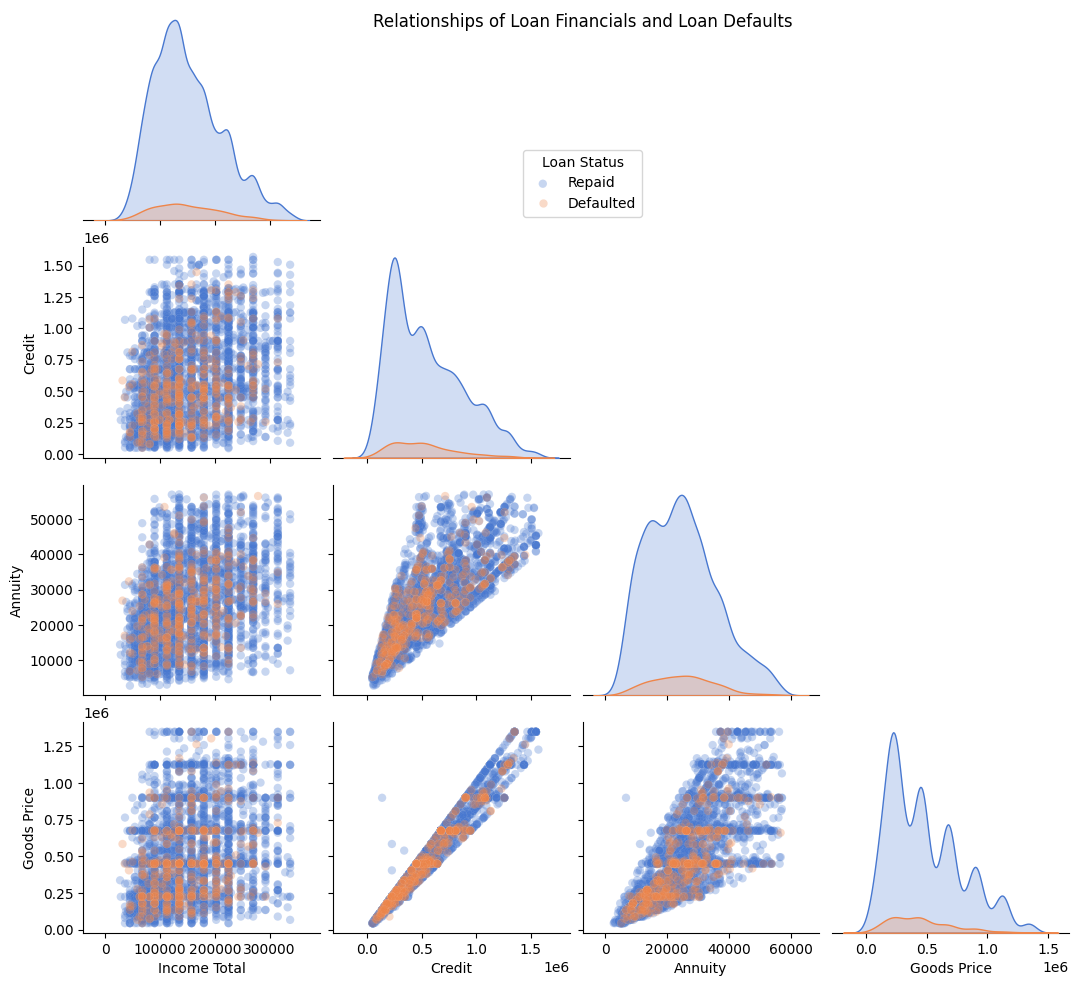

In [34]:
amount_cols = []

for col in loans.columns:
  if "AMT_" in col and "REQ" not in col:
    amount_cols.append(col)

amt_df = loans[amount_cols + ["TARGET"]]

for col in amount_cols:
    print(col, ":")
    amt_df = hl.remove_outliers(amt_df, col)
    print("")

amt_df = amt_df.sample(5000, random_state=42)

amt_df.columns = amt_df.columns.str.replace("AMT_", "").str.replace(
    "_", " ").str.title()

amt_cols = amt_df.columns.to_list()[0:4]
amt_df = amt_df.sort_values(by="Target", ascending=True)

g = sns.pairplot(data=amt_df, x_vars=amt_cols, y_vars=amt_cols, hue="Target",
                 plot_kws={"alpha": 0.3, "linewidth": 0.1}, corner=True,
                 **style_params)

g.fig.set_size_inches(12, 10)

handles = g._legend_data.values()
labels = ["Repaid", "Defaulted"]

g._legend.remove()
g.fig.legend(title="Loan Status", labels=labels,
             loc="upper center", bbox_to_anchor=(0.5, 0.85))

g.fig.suptitle("Relationships of Loan Financials and Loan Defaults",
               y=0.98, fontsize=12)

plt.show()

* We see a very linear relationship between the amount of Credit and the Goods Price.
* There also seems to be a linear relationship between Credit and Annuity, although there most likely is another factor influencing the relationship.
  * Best guess would be loan term (as in how many months will it take to repay the loan).
* Income does not seem to have a visible relationship with other columns
* No clearly visibly pattern can be observed between loans that default and the ones that don't from combination of these features.

Now, let's look at the relationships between "DAYS_" columns

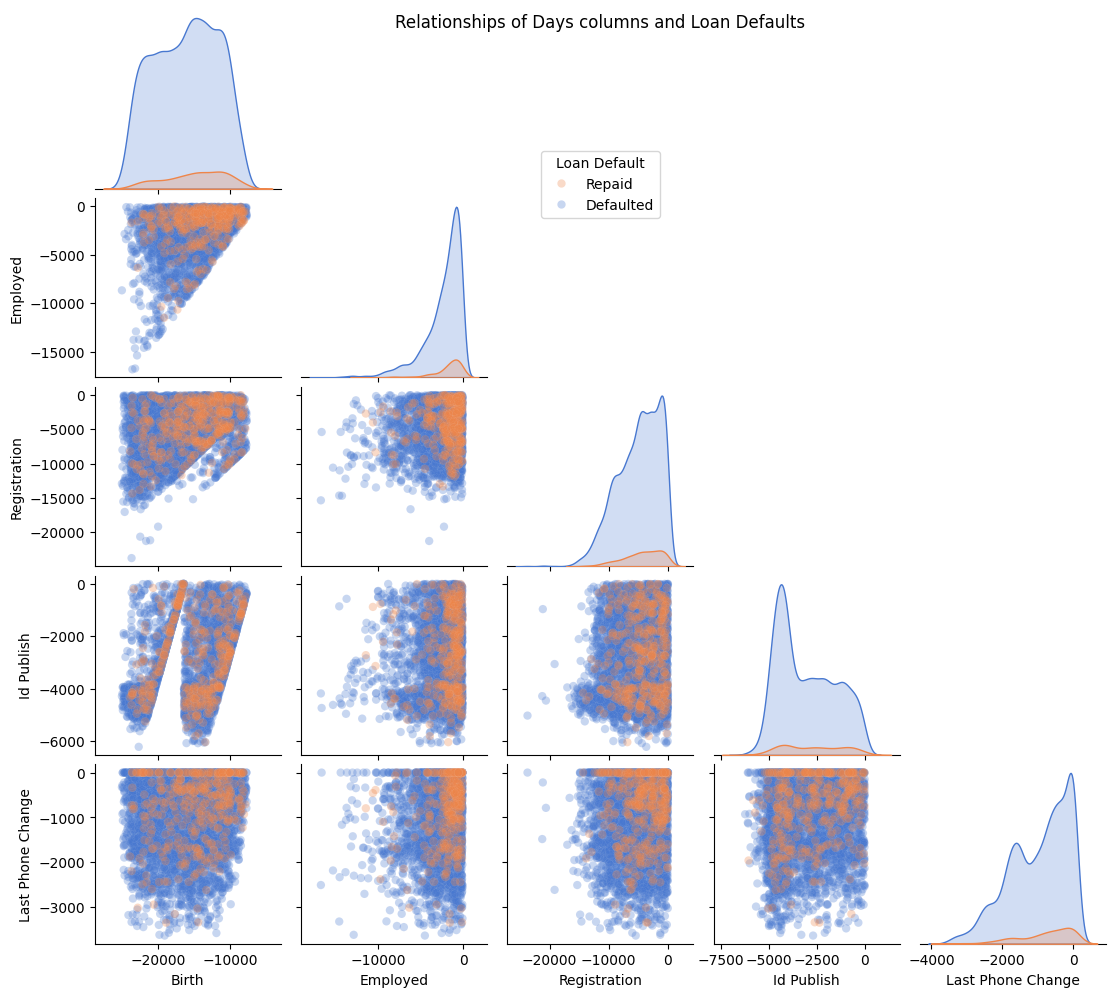

In [35]:
days_cols = []

for col in loans.columns:
  if "DAYS_" in col:
    days_cols.append(col)

days_cols = days_cols[:-1]


days_df = loans[days_cols + ["TARGET"]].sample(5000, random_state=42)

days_df.columns = days_df.columns.str.replace("DAYS_", "").str.replace(
    "_", " ").str.title()

days_cols = days_df.columns.to_list()[0:len(days_cols)]
days_df = days_df.sort_values(by='Target', ascending=True)

g = sns.pairplot(data=days_df, x_vars=days_cols, y_vars=days_cols, hue="Target",
                 plot_kws={"alpha": 0.3, "linewidth": 0.1}, corner=True,
                 **style_params)

g.fig.set_size_inches(12, 10)

labels = ["Repaid", "Defaulted"]
g._legend.remove()
g.fig.legend(title="Loan Default", handles=handles, labels=labels,
             loc="upper center", bbox_to_anchor=(0.5, 0.85))

g.fig.suptitle("Relationships of Days columns and Loan Defaults\n",
               y=0.98, fontsize=12)

plt.show()

* Interesting shapes appear in scatter plots with "Birth" column, showing that being an adult is a prerequisite for taking out a loan. In the scatter plot with "ID Publish" column we can even see a pattern of when IDs are typically renewed.
* No strong relationships with the target variable are visible. Although, there seem to be less loan defaults when the Employment Length is longer, as most of the defaults are concentrated on the lower end.

Now let's move on to other files in the dataset.

# Previous Applications

We'll begin by looking at previous loans. Before approving the loan, HomeCredit looks into previous loans that the applicant had with them, if any.

In [36]:
prev = pd.read_csv(dir_path + "original_data/previous_application.csv")

# filtering to avoid snooping on test data
prev = prev[prev["SK_ID_CURR"].isin(loans["SK_ID_CURR"])]

print(prev.shape)
prev.head()

(1272294, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.000,17145.000,0.000,17145.000,SATURDAY,15,Y,1,0.000,0.183,0.867,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.000,middle,POS mobile with interest,365243.000,-42.000,300.000,-42.000,-37.000,0.000
1,2802425,108129,Cash loans,25188.615,607500.000,679671.000,NaN,607500.000,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.000,low_action,Cash X-Sell: low,365243.000,-134.000,916.000,365243.000,365243.000,1.000
2,2523466,122040,Cash loans,15060.735,112500.000,136444.500,NaN,112500.000,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.000,high,Cash X-Sell: high,365243.000,-271.000,59.000,365243.000,365243.000,1.000
3,2819243,176158,Cash loans,47041.335,450000.000,470790.000,NaN,450000.000,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.000,middle,Cash X-Sell: middle,365243.000,-482.000,-152.000,-182.000,-177.000,1.000
4,1784265,202054,Cash loans,31924.395,337500.000,404055.000,NaN,337500.000,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.000,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


Just looking at the structure of the file right away we see differences in how data is stored for new applications and previous ones:
* Previous loans have much less columns, only 37.
* However, there are some columns that are present here that aren't in the "current" applications file:
  * Down Payment
  * "Rate" columns
  * Client type (Repeater vs New)
  * Count Payments ("CNT_PAYMENT)
  * Yield group (low, medium, high)


In [37]:
nulls_info = hl.get_null_info(prev)
nulls_info.set_index("Column", inplace=True)
display(nulls_info)
most_nulls = nulls_info.T.sort_values(by="As Percentage", ascending=False)
print("In this dataset -",len(most_nulls[most_nulls["As Percentage"] >= 50]),
      "out of", prev.shape[1], "columns have at least half rows missing.")

display(most_nulls.head(10))

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
Column,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Null Counts,0.000,0.000,0.000,276738.000,0.000,1.000,674636.000,287785.000,0.000,0.000,0.000,0.000,674636.000,1268015.000,1268015.000,0.000,0.000,0.000,0.000,0.000,625239.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,276733.000,0.000,282.000,505180.000,505180.000,505180.000,505180.000,505180.000,505180.000
As Percentage,0.000,0.000,0.000,21.751,0.000,0.000,53.025,22.619,0.000,0.000,0.000,0.000,53.025,99.664,99.664,0.000,0.000,0.000,0.000,0.000,49.143,0.000,0.000,0.000,0.000,0.000,0.000,0.000,21.751,0.000,0.022,39.706,39.706,39.706,39.706,39.706,39.706


In this dataset - 4 out of 37 columns have at least half rows missing.


Column,Null Counts,As Percentage
RATE_INTEREST_PRIVILEGED,1268015.000,99.664
RATE_INTEREST_PRIMARY,1268015.000,99.664
AMT_DOWN_PAYMENT,674636.000,53.025
RATE_DOWN_PAYMENT,674636.000,53.025
NAME_TYPE_SUITE,625239.000,49.143
NFLAG_INSURED_ON_APPROVAL,505180.000,39.706
DAYS_TERMINATION,505180.000,39.706
DAYS_LAST_DUE,505180.000,39.706
DAYS_LAST_DUE_1ST_VERSION,505180.000,39.706
DAYS_FIRST_DUE,505180.000,39.706


Some columns have a lot of missing data. We will avoid looking at them. Let's begin by seeing how many of current loan applications had previous applications beforehand.

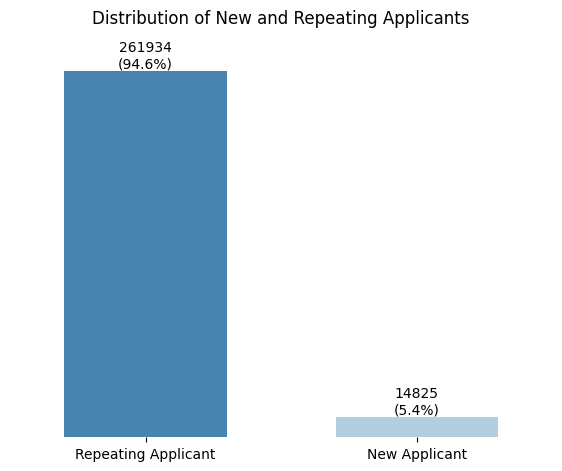

In [38]:
assert set(prev["SK_ID_CURR"].unique()) - set(loans["SK_ID_CURR"].unique()) == set()

counts_df = pd.DataFrame({
    "Category": ["Repeating Applicant", "New Applicant"],
    "Count": [
        prev["SK_ID_CURR"].nunique(),
        loans["SK_ID_CURR"].nunique() - prev["SK_ID_CURR"].nunique()]
})

plt.figure(figsize=(7, 5))
my.plot_barchart(counts_df)
plt.title("Distribution of New and Repeating Applicants\n")
plt.show()

We have previous applications data on majority of the current loan applicants, which is reassuring.

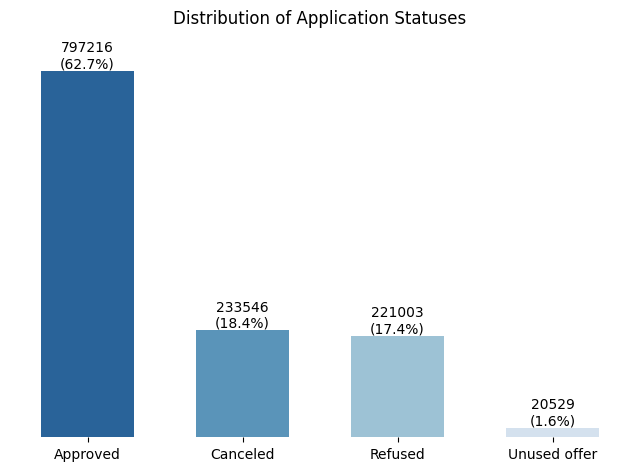

In [39]:
counts_df = prev["NAME_CONTRACT_STATUS"].value_counts().reset_index()

plt.figure(figsize=(8, 5))
my.plot_barchart(counts_df)
plt.title("Distribution of Application Statuses\n")
plt.show()

We see that majority of the applications were in fact approved.

In [40]:
prev.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.000,17145.000,0.000,17145.000,SATURDAY,15,Y,1,0.000,0.183,0.867,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.000,middle,POS mobile with interest,365243.000,-42.000,300.000,-42.000,-37.000,0.000
1,2802425,108129,Cash loans,25188.615,607500.000,679671.000,NaN,607500.000,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.000,low_action,Cash X-Sell: low,365243.000,-134.000,916.000,365243.000,365243.000,1.000
2,2523466,122040,Cash loans,15060.735,112500.000,136444.500,NaN,112500.000,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.000,high,Cash X-Sell: high,365243.000,-271.000,59.000,365243.000,365243.000,1.000
3,2819243,176158,Cash loans,47041.335,450000.000,470790.000,NaN,450000.000,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.000,middle,Cash X-Sell: middle,365243.000,-482.000,-152.000,-182.000,-177.000,1.000
4,1784265,202054,Cash loans,31924.395,337500.000,404055.000,NaN,337500.000,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.000,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
prev_approved = prev[prev["NAME_CONTRACT_STATUS"]=="Approved"]
print(prev_approved.shape)
print(prev_approved["SK_ID_CURR"].nunique())

(797216, 37)
261027


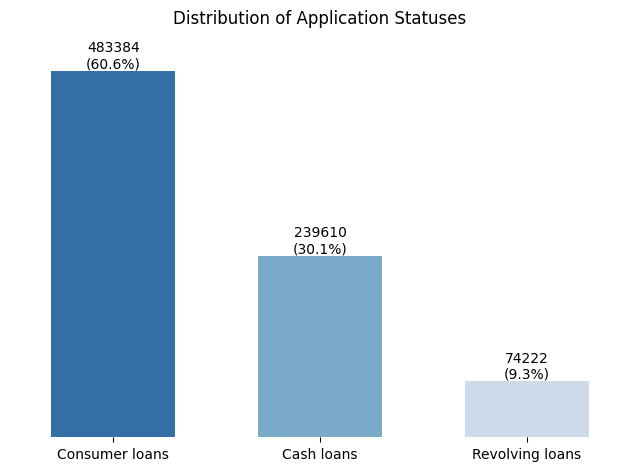

In [42]:
counts_df = prev_approved["NAME_CONTRACT_TYPE"].value_counts().reset_index()

plt.figure(figsize=(8, 5))
my.plot_barchart(counts_df)
plt.title("Distribution of Application Statuses\n")
plt.show()

What's interesting to see is that we have an additional category in the previous application: "Consumer loans".

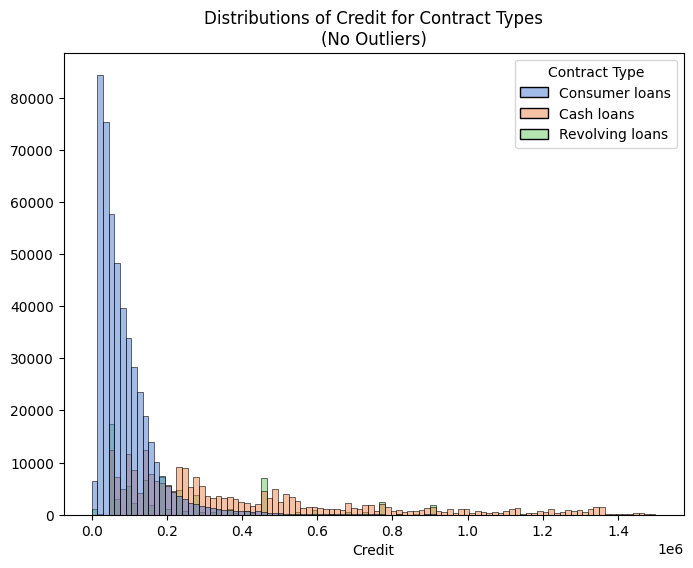

In [43]:
plt.figure(figsize=(8,6))

ax = sns.histplot(data=prev_approved[prev_approved["AMT_CREDIT"]<1.5e6],
             x="AMT_CREDIT", hue="NAME_CONTRACT_TYPE",
             bins=100, alpha=0.5, palette="muted")

plt.xlabel("Credit")
plt.ylabel("")
plt.title("Distributions of Credit for Contract Types\n(No Outliers)")
ax.get_legend().set_title("Contract Type")

plt.show()

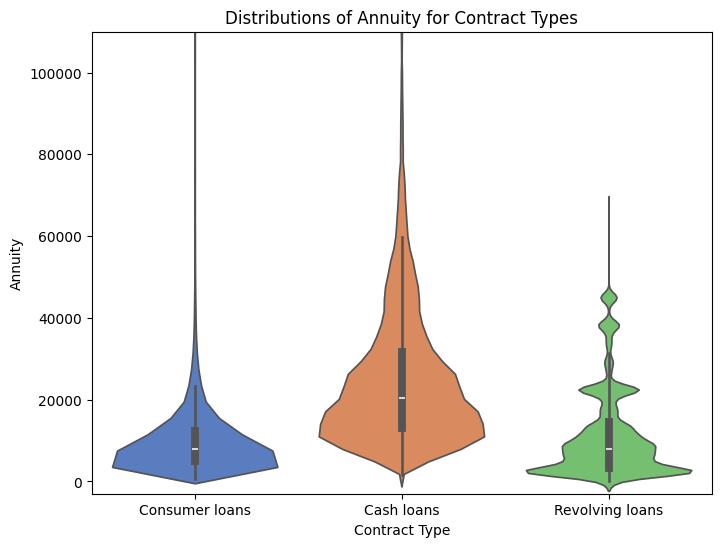

In [44]:
plt.figure(figsize=(8,6))

sns.violinplot(data=prev_approved,
               x="NAME_CONTRACT_TYPE", y="AMT_ANNUITY",
               palette="muted")

plt.xlabel("Contract Type")
plt.ylabel("Annuity")
plt.title("Distributions of Annuity for Contract Types")

plt.ylim(-3e3, 1.1e5)

plt.show()

From the chart we see that Consumer loans have lower annuity amounts than cash loans. Revolving loans also have a lower values of annuity, although it's harder to compare, as the sample is smaller and the distribution of values is more erratic.

An interesting column that is not in the main file is "NAME_YIELD_GROUP", so let's take a look if we can get anything useful from it.

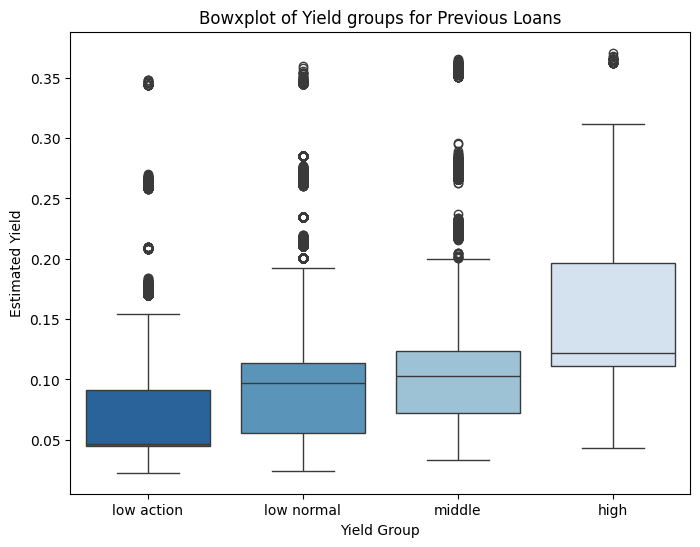

In [45]:
prev_approved["yield"] = prev_approved["AMT_ANNUITY"] / prev_approved["AMT_CREDIT"]

name_yield_order = ["low_action", "low_normal", "middle", "high"]

plt.figure(figsize=(8, 6))

sns.boxplot(data=prev_approved[prev_approved["NAME_YIELD_GROUP"]!="XNA"],
            x="NAME_YIELD_GROUP", y="yield",
            order=name_yield_order, palette="Blues_r")

plt.xlabel("Yield Group")
plt.ylabel("Estimated Yield")
plt.title("Bowxplot of Yield groups for Previous Loans")

ax = plt.gca()
my.wrap_labels(ax=ax, width=11)

plt.show()

It seems that the yield groups are ordinal, which is good to know.

# Summary

### **Most borrowers are**:
* Female (65%),
* Married (74% including civil marriage),
* Have no (or up to 2) children,
* Have secondary education (71%) with about 24% having a higher education.
* Ages range from 20 to 69 years, with the average age of ~44 years.

### **Data on loans**:
* Most loans are "Cash loans" (90%), with the remaining being "Revolving loans" (10%).
    * Interestingly, previous loan applications have a third category: "Consumer loans", which is the majority of previous loans related to current borrowers.
* About 8% of loans are marked as **defaulted** in our target variable.
* Amount columns all follow a normal distribution that is rightly skewed and outliers on the high end.
* Average amounts:
    * Credit: 600k
    * Goods Price: 540k
    * Annuity: 27k
    * Borrower Income: 170k
* There are clear linear relationships between Credit, Goods Price and Annuity.
* We have 3 External Source columns that are normalized, and that have visibly different distributions for defaulted and paid off loans.

### **In previous applications we saw**:
* That we had previous applications for majority (95%) of current loan applicants, making the file very useful for later prediction tasks.
* Around 63% of previous applications in our sample were approved.
* The structure of data stored on previous and current applications is quite different. We have less columns for previous applications, but some of them are not present in the current loans.
* For instance, we see that previous applications can be grouped by yield groups.
